# pyEnRICH Tutorial: Sample Dataset Analysis

This notebook will take you through how to use pyEnRICH: a PYthon framework for Enriched Radial Intensity Calculations for Hubs. This tutorial will lead you through the data analysis for calculating radial enrichment of a fluorescently tagged protein co-localized to a spot of nascent transcription. This involves the following steps:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1. Importing datasets.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2. Visualizing select timepoints.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;3. Parameter selection.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;4. Processing. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;5. Results and interpretation. 

This notebook was created first to test out our sample data which can be found here: https://doi.org/10.5281/zenodo.10794049
Further details on how to use this code and the upstream sample prep and image acquisition for the data can be found in the main text of our protocol chapter.

### 1. Importing datasets.

First, make sure that this Python notebook is running within the "pyEnRICH_env" created when you installed this program. This environment will have the dependencies installed needed to run this analysis.

In [2]:
# importing pyEnRICH fucntions for processing/analysis and napari for image visualization
from pyEnRICH_lib import *
import napari

Next, input your dataset. This is done through updating the input CSV that you can find in the pyEnRICH_sample_data folder. The CSV for the sample dataset is provided within this pacakage. When running your own data, add another row to the CSV for each new dataset and each dataset will be ran one after the other. It should be noted that you will have to change the paths for "Idir" and "output_path" before you can run the sample data. The following are descritpions for the parameters are the columns of the input CSV:


*Variables*

>**Idir:** (aka Image DIRectory) This should be a string of your path to the folder containing your timelapse images where each stack is saved as a separate timepoint/tiff file. This will need to be updated depending on where you store the sample dataset. 

>**output_path:** This should be a string of your path of the folder you would like all the generated analysis files to be stored in. This will need to be updated depending on where you would like to store the output data. 

>**sample_id:** I always label my data sets with an identification code that will be easily understood when comapring across different dataset. Often I put the gene tagged with MS2 in this id. It's important to note that this code is meant to process images within interphase of one nuclear cycle. There might be some artifacts generated if you image across nuclear divisions and parameters might need to be readjusted for each nuclear cycle. 

>**TF_CHANNEL:** Images were acquired simultaneously in two cameras. These channel parameters refer to which of the two channels (0 or 1) your transcrription factor of interest appears in. In this case it is channel 0.

>**MCP_CHANNEL:** Images were acquired simultaneously in two cameras. These channel parameters refer to which of the two channels (0 or 1) MCP appears in. In this case it is channel 1.

>**Z_Bounds_start:** This variable is used to crop the raw image in case there are some stacks excluded in the decon image. If the number of Z-stacks is NOT equivalent between the raw and deconvolved images an error will be raised. You should observe the discrepancy and adjust this parameter as necessary. If there is no discrepancy in this number set Z_Bounds = None. For example, in this dataset the raw images have 68 stacks while the deconvolved images have 64. Upon closer inspection, the deconvolved image appears to remove the first two and last two stacks in the raw images. Therefore, Z_bounds_start = 2 and Z_bounds_end = 66. If there is NO discrepancy between the shapes of the raw and deconvolved images, then set  Z_bounds_start = 0 and Z_bounds_end = 0.

>**Z_Bounds_end:** See above for further description how to use this variable. 

>**save_edges:** This variable will allow you to save images of any spots that are MCP spots within nuclei but are on the nuclear periphery. By default, if this is False, then you will not be saving these "edge" points resulting in a dataset that only contains when the MS2 spot is 1 micron interior to the nuclear envelope. 

>**threshold:** This variable denotes a percentile threshold values for segmenting MS2 spots. Change this variable first to optimize MS2 segmentation. If using nuclear masks, I find that you need a much smaller threshold (97) rather than a tighter threshold used when not using nuclear masks (99.997). Do not worry about the exact value. Further in this notebook we will manually adjust this. 

>**sigma_low:** This variable denotes a low sigma value for a difference of gaussians. Only change this if a MS2 spots cannot be segmented just changing a threshold. Do not worry about the exact value. Further in this notebook we will manually adjust this. 

>**sigma_high:** This variable denotes a high sigma value for a difference of gaussians. Only change this if a MS2 spots cannot be segmented just changing a threshold. Do not worry about the exact value. Further in this notebook we will manually adjust this. 


>**window_crop:** This variable denotes how large (in pixels) your cropped window centered at an MS2 spot is. The default value of 11 in the script creates 1.1um windows in the sample dataset. This value has been chosen arbitrarily since we do not foresee hub enrichment greater than a micron away influencing transcription of this target gene. 

>**masks_provided:** This variable denotes if nuclear masks are provided and you would like to use them. It should be noted that we HIGHLY recommend starting with already segmented images as it increases the reliability in calling MS2 spots in and outside of the nucleus. 

>**nuclearcycle:** The following six variables contain which nuclear cycles/stages you are imaging and when each interphase starts and ends. If there is no nuclcear cycle detected in the dataset please set these values to zero. For instance, the sample data only contained interphase of NC13 and the interphase starts on the 110th stack and ends on the 230th stack. Thus, NC12_start = 0, NC12_end = 0, NC13_start = 110, NC13_end = 225, NC14_start = 0, NC14_end = 0. These variables can be easily interchanged depending on your sample and staging needs. 

>**NC12_start:** See above.

>**NC12_end:** See above.

>**NC13_start:** See above.

>**NC13_end:** See above.

>**NC14_start:** See above.

>**NC14_end:** See above.

*Functions*

>**pyEnRICH.read_CSV**: This function reads in your CSV file and stores each parameter. It also creates a directory based on your output_path if the path doesn't exist. 

>**pyEnRICH.initialize**: This function reads in your tiff files contained in the Idir and creates an output_path if it does not already exist. 

In [3]:
# input your data sets here
path_to_dataset_parameters_CSV = "/Volumes/mirlab/S/Data/pyEnRICH_sample_data/dataset_parameters.csv"
row_number = 0 #row_number refers to which dataset you want to analyze

# read the dataset parameters
dataset_parameters = read_CSV(path_to_dataset_parameters_CSV, row_number)
print(dataset_parameters)

Idir                             /Volumes/mirlab/S/Data/pyEnRICH_sample_data/Data
output_path                     /Volumes/mirlab/S/Analysis/20240304_pyEnRICH_s...
sample_id                                                          20230109_SNA_2
TF_CHANNEL                                                                      0
MCP_CHANNEL                                                                     1
Z_Bounds_start                                                                  2
Z_Bounds_end                                                                   66
save_edges                                                                   True
threshold                                                                      97
sigma_low                                                                     1.5
sigma_high                                                                      6
max_size                                                                      600
nuclear_point   

In [4]:
#Initialize imaging datasets and create output_path of it does not already exist
#IMG, DIMG, MIMG contains the lists of tiff file names that will later be read in to open individual stacks 
image_directory = dataset_parameters["Idir"]
IMG = initialize(image_directory, type="raw image")
DIMG = initialize(f"{image_directory}/GPUdecon", type="deconvolved image")

if dataset_parameters["masks_provided"]:
    MIMG = initialize(f"{image_directory}/Tracked_Masks", type="nuclear mask") 

### 2. Visualizing select timepoints.

To visualize a timepoint, we will input a tiff stack of one timepoint into [napari, a multi-dimension image viewer for Python.](https://napari.org/stable/)

We will start by using one time point (select toward the beginning of your nuclear cycle/interphase) to acquire parameters for segmentation of the MS2 spot of active transcription. Once one time point is optimized, we will go back and test on an additional two time points (select in the end and middle of your nuclear cycle/interphase).

*Variables*

>**t:** This is where to store a timepoint of interest to view and test segmentation parameters on. I often start toward the middle of a nuclear cycle where I know there will be MS2 spots and then go toward the beginning and end of the dataset. 

>**viewer:** This variable is your napari viewer for visualization purposes. 

*Fucntions*

>**pyEnRICH.initalize_viewer:** This function opens a napari viewer and inserts widgets into the GUI for parameter optimization (discussed in the next section). 

>**pyEnRICH.open_image:** This function accepts your IMG, MCP channel, and timepoint and initializes a napari viewer containing your set timepoint. This also opens your nuclear mask image if and only if they are provided.

In [9]:
#input your timepoint you would like to start testing here
t = 5

#open image
viewer = initialize_viewer()
Image = open_image(IMG, dataset_parameters['MCP_CHANNEL'], t, [dataset_parameters["Z_Bounds_start"], dataset_parameters["Z_Bounds_end"]], viewer, "raw") 
DeconImage = open_image(DIMG, dataset_parameters['MCP_CHANNEL'], t, [dataset_parameters["Z_Bounds_start"],dataset_parameters["Z_Bounds_end"]], viewer, "decon") 
if dataset_parameters["masks_provided"]:
    MaskImage = open_image(MIMG, 0, t, [dataset_parameters["Z_Bounds_start"],dataset_parameters["Z_Bounds_end"]], viewer, "nuclear mask")
else:
    MaskImage = None
napari.run()

### 3. Parameter selection.

Next, we will need to optimize the parameters used for segmentation. Segmentation of the MS2 spot using a difference of gaussians (DOG) followed by a percentile threshold. Use the sample code to assess what "good" segmentation consists of. My point of reference is to have as minimal background spots in the final labels image - this might mean dropping a few MS2 spots in favor of reducing background. Having a minimal amount of background lables (those not in the nucleus) is alright as the downstream analysis will be able to discern segmented labels as either nuclear or non-nuclear. 

I've found across datasets that the parameter needing adjusting between datasets is the threshold value used within the segmentation code and not usually the DOG sigma values. 

Note: if adjusting the threshold value proves futile for proper segmentation, then change the sigma values in the gaussian filters. This should be a last resort instead of something to manipulate on the first pass. 

*Variables*

>**sigma_high:** This variable denotes a high sigma value for a difference of gaussians. Only change this if a MS2 spots cannot be segmented just changing a threshold.

>**sigma_low:** This variable denotes a low sigma value for a difference of gaussians. Only change this if a MS2 spots cannot be segmented just changing a threshold.

>**threshold:** This variable denotes a percentile threshold values for segmenting MS2 spots. Change this variable first to optimize MS2 segmentation. If using nuclear masks, I find that you can use a much smaller threshold (~97) rather than a tighter threshold used when not using nuclear masks (~99.997).

*Functions*

>**pyEnRICH.difference_of_gaussians_parameter_selection:** This function will perform a difference of gaussians filter and make the result viewable in napari. This is what is generating the widget foudn on the left hand side of the window. 

>**pyEnRICH.threshold_parameter_selection:** This function will perform a the full segmentation process and make the resulting label matrix viewable in napari.

 You will see in Dock widget 1 the ability to change the two sigma values. The default is 1.5 and 6, but feel free to adjust and hit the Run button to play with different DoG filters. NOTE: you will need to adjust the "image" via a drop down menu to the deconvolved image. I find that the deconvolved image works best when masks are provided and the DoG filter on the raw image is best to not have as many cytoplasmic points when masks are not provided. 

You will see the threshold selection in Dock widget 2. Here you will need to set the image to the DOG filtered image to threshold. "D_MCP" should be set to your deconvolved image if masks provided and the raw image if masks are not provided. The threshold value is displayed on the sliding bar. The masks_provided should be checked if masks are provided. Additionally, if masks are provided then you need to set M in the drop down menu to your nuclear masks. Additionally you may adjust the max size which is the maximum size (in pixels) your MS2 spot can be as any objects this value or larger will be filtered out. 

In [ ]:
#repeat with another timepoint (at beginning of the dataset)

#input values 
t = 0 #timepoint

#open image
Image = open_image(IMG, dataset_parameters['MCP_CHANNEL'], t, [dataset_parameters["Z_Bounds_start"], dataset_parameters["Z_Bounds_end"]], viewer, "raw") 
DeconImage = open_image(DIMG, dataset_parameters['MCP_CHANNEL'], t, [dataset_parameters["Z_Bounds_start"],dataset_parameters["Z_Bounds_end"]], viewer, "decon") 
if dataset_parameters["masks_provided"]:
    MaskImage = open_image(MIMG, 0, t, [dataset_parameters["Z_Bounds_start"],dataset_parameters["Z_Bounds_end"]], viewer, "nuclear mask")
else:
    MaskImage = None

In [ ]:
#repeat with another timepoint (at end of the dataset)

#input values 
t = 5 #timepoint

#open image
Image = open_image(IMG, dataset_parameters['MCP_CHANNEL'], t, [dataset_parameters["Z_Bounds_start"], dataset_parameters["Z_Bounds_end"]], viewer, "raw") 
DeconImage = open_image(DIMG, dataset_parameters['MCP_CHANNEL'], t, [dataset_parameters["Z_Bounds_start"],dataset_parameters["Z_Bounds_end"]], viewer, "decon") 
if dataset_parameters["masks_provided"]:
    MaskImage = open_image(MIMG, 0, t, [dataset_parameters["Z_Bounds_start"],dataset_parameters["Z_Bounds_end"]], viewer, "nuclear mask")
else:
    MaskImage = None

IMPORTANT: After finding optimal parameters, please input them into the dataset_parameters.csv and save the file. This will ensure that when we run the whole dataset, the right parameters are used. Write them into the following box as a place holder and for downstream boxes. 

In [11]:
#parameter summary so far
sigma_low = 1.5
sigma_high = 6
threshold = 97
max_size = 600

Next, as an internal control, we need to map the coordinates of a point that is known to be within a nucleus that does *not* have an active MS2 spot and a point in the cytoplasm. These points will be used to normalize background intensities and also denote if segmented objects are within the nucleus, at the nuclear edge, or in the cytoplasm. **You will only have to do this if masks are NOT provided.**

*Variables*

>**nuclear_point:** This is the pixel coordinates of a spot within an inactive nucleus. The format is as follows: [timepoint, Z, Y, X]. Otherwise = None.

>**cytoplasmic_point:** This is the pixel coordinates of a spot within the cytoplasm. The format is as follows: [timepoint, Z, Y, X]. Otherwise = None.

In [13]:
 #selecting a nuclear and a cytoplasmic point 
if dataset_parameters["masks_provided"]:
    nuclear_point = None
    cytoplasmic_point = None
else: 
    nuclear_point = [5, 40, 457, 188] #[T, Z, Y, X]
    cytoplasmic_point = [5, 40, 492, 224] #[T, Z, Y, X]

Next, we want to make sure that we are calling spots based on whether or not they are withing the nucleus or the cytoplasm. If a spot is within the nucleus, we further want to make sure that we separate MS2 spots that are on the edge of the nucleus.

When NOT providing nuclear masks, to insure that the code is calling nuclear and cytoplasmic points correctly, we show here a test of the localization classification and the generation of random spots. Here, you will see that all spots counted as nuclear will have two or three random spots generated surrounding it. We will want to make sure the random spots are appropriately contained within the nucleus. If there are too little nuclear classifications, then adjust the adjustment value from 1 (no adjustment) to higher values (1.05, 1.1). If there are too many random spots outside fo the nucleus, then lower this adjustment value (0.95). Additionally, this piece of code opens the segmentation mask generated before but now has values marking if a spot will be classified as nuclear or as an edge (on the nuclear periphery). Hover over the spots to assess if a value is an edge (=10) or nuclear (=20). By changing the adjustment_factor you will be changing the classification. I find that this factor is important to change if your signal to noise ratio is low.

In the below code box, you will generate 4 points layers in napari. The Edge Sites points will display as white and designate MS2 spots that are too close to the nuclear periphery to be evaluated as non-edge sites. The Transcription Sites points will display as green spots that are non-edges and are used inthe final calculations. Additionally, "Edge Random Spots" and "Transcription Random Spots" have their own layers and will produce points (in white and green respectively) adjacent to their MS2 spots. I use this "check_nucleus_image" function in order to make sure that transcirption sites, edge sites, and random spots look as intended. 

In [14]:
if dataset_parameters["masks_provided"]:
    adjustment_factor = None
else:
    adjustment_factor = 1.0 #for finer adjustments to the nuclear and cytoplasmic points


#generate MS2 spotmask
SpotMaskImage = generate_spotmask(Image, sigma_low, sigma_high, viewer, DeconImage, threshold, masks_provided = dataset_parameters['masks_provided'], M = MaskImage, max_size = max_size)

#check categorization of MS2 spots
check_nucleus_image(t, 
                    DIMG, 
                    SpotMaskImage, 
                    Image, 
                    DeconImage, 
                    nuclear_point, 
                    cytoplasmic_point, 
                    viewer, 
                    adjustment_factor = adjustment_factor, 
                    MCP_CHANNEL = dataset_parameters['MCP_CHANNEL'], 
                    window_crop = dataset_parameters['window_crop'], 
                    masks_provided = dataset_parameters['masks_provided'], 
                    nuc_mask = MaskImage, 
                    save_edges = dataset_parameters["save_edges"])

### 4. Processing.

Now that we have optimized parameters we will need to run all the processing on the time points in the dataset. This code will segment the MS2 points, label and confirm them as transcription sites(TS), determine if the TS is at the edge of the nucleus or not, crop out small windows, generate radial profiles, and save intermediate images and csv files in an output folder. 

The "process one time point at a time" box should be used if you do not have access to high performance clusters (HPC) or if you do not have over 16GB of RAM. 

For multiprocessing, see the "pyEnRICH_lib.py" script.

*Variables*

>**amount_of_processes:** this refers to the number of proccesses you would like to run in parallel (in case you wish to do parallel processing)

*Functions*

>**pyEnRICH.spot_segmentation_and_crop:** This function takes in *one* timepoint and does the following: (1) segments MS2 spots, (2) validates each object's nuclear localization, (3) finds random sites and nuclear edge sites, (4) saves segmentation and csvs of each MS2 spot's properties for each timepoint, and (5) generate and save cropped images centered around the weighted centroid position of the transcription sites, random sites, and edge sites. 


NOTE: This may take a while to run! 

In [39]:
#serial processing
nuclearcycle = nuclearcycle = [
        ('NC12', [dataset_parameters['NC12_start'], dataset_parameters['NC12_end']]),
        ('NC13', [dataset_parameters['NC13_start'], dataset_parameters['NC13_end']]),
        ('NC14', [dataset_parameters['NC14_start'], dataset_parameters['NC14_end']])
    ]

Z_Bounds = [dataset_parameters["Z_Bounds_start"],dataset_parameters["Z_Bounds_end"]]
if Z_Bounds == [0,0]:
    Z_Bounds = None

if isinstance(nuclearcycle, str):      
    nuclearcycle = [nuclearcycle]
for nc, nc_t in nuclearcycle:
    NC_start = nc_t[0]
    NC_end   = nc_t[1]
    for t in range(NC_start, NC_end): 
        spot_segmentation_and_crop(t, 
                                IMG = IMG, 
                                DIMG = DIMG,
                                MIMG = MIMG, 
                                sample_id = dataset_parameters["sample_id"],
                                nuclearcycle = nuclearcycle,
                                input_dir = dataset_parameters["Idir"],
                                output_dir = dataset_parameters["output_path"],
                                sigma_high = sigma_high,
                                sigma_low = sigma_low,
                                nuclear_point = nuclear_point,
                                cytoplasmic_point = cytoplasmic_point,
                                thresh_value = threshold,
                                adjustment_factor = adjustment_factor,
                                TF_CHANNEL = dataset_parameters['TF_CHANNEL'],
                                MCP_CHANNEL = dataset_parameters['MCP_CHANNEL'], 
                                window_crop = dataset_parameters['window_crop'],
                                Z_Bounds = Z_Bounds,
                                save_edges = dataset_parameters["save_edges"],
                                masks_provided = dataset_parameters["masks_provided"])

Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 111


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00110.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 112


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00111.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 113


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00112.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 114


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00113.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 115


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00114.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 116


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00115.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 117


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00116.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 118


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00117.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 119


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00118.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 120


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00119.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 121


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00120.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 122


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00121.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 123


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00122.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 124


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00123.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 125


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00124.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 126


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00125.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 127


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00126.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 128


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00127.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 129


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00128.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 130


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00129.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 131


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00130.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 132


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00131.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 133


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00132.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 134


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00133.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 135


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00134.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 136


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00135.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 137


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00136.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 138


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00137.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 139


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00138.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 140


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00139.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 141


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00140.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 142


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00141.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 143


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00142.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 144


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00143.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 145


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00144.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 146


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00145.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 147


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00146.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 148


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00147.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 149


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00148.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 150


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00149.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 151


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00150.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 152


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00151.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 153


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00152.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 154


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00153.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 155


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00154.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 156


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00155.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 157


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00156.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 158


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00157.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 159


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00158.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 160


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00159.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 161


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00160.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 162


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00161.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 163


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00162.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 164


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00163.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 165


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00164.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 166


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00165.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 167


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00166.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 168


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00167.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 169


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00168.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 170


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00169.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 171


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00170.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 172


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00171.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 173


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00172.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 174


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00173.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 175


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00174.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 176


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00175.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 177


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00176.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 178


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00177.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 179


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00178.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 180


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00179.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 181


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00180.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 182


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00181.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 183


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00182.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 184


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00183.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 185


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00184.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 186


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00185.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 187


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00186.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 188


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00187.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 189


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00188.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 190


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00189.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 191


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00190.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 192


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00191.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 193


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00192.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 194


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00193.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 195


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00194.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 196


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00195.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 197


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00196.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 198


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00197.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 199


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00198.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 200


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00199.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 201


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00200.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 202


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00201.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 203


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00202.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 204


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00203.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 205


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00204.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 206


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00205.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 207


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00206.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 208


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00207.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 209


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00208.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 210


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00209.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 211


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00210.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 212


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00211.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 213


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00212.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 214


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00213.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 215


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00214.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 216


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00215.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 217


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00216.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 218


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00217.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 219


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00218.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 220


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00219.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 221


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00220.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 222


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00221.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 223


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00222.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 224


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00223.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


Processing 20230109_SNA_2_no_mask_NC13 Image. Timepoint = 225


/Users/fallacaros/Desktop/pyEnRICH/pyEnRICH/read_mosaic.py:111: UserWarning: /Volumes/mirlab/S/Data/pyEnRICH_sample_data_no_masks/Data/MS2_Masks/MS2_Masks_CH1_CamB_T00224.tif is a low contrast image
  skimage.io.imsave(f"{filename}_CH{ch}_{CAMS[ch]}_T{str(t).rjust(5, '0')}.tif", img)


### 5. Results and interpretation.

Congrats! You have made it through pyEnRICH! Now, there's one thing left to do: visualize and interpret our data analysis. 

*Variables*

>**nuclearcycle:** This referes to which individual nuclear cycle you would like to plot.

*Functions*

>**pyEnRICH.generate_figures:** Use this code to analyze and build graphs for your enrichment dataset. 

>**pyEnRICH.see_results:** This function will open and visualize your normailzed cropped areas and a radial profile graph to assess enrichment! 

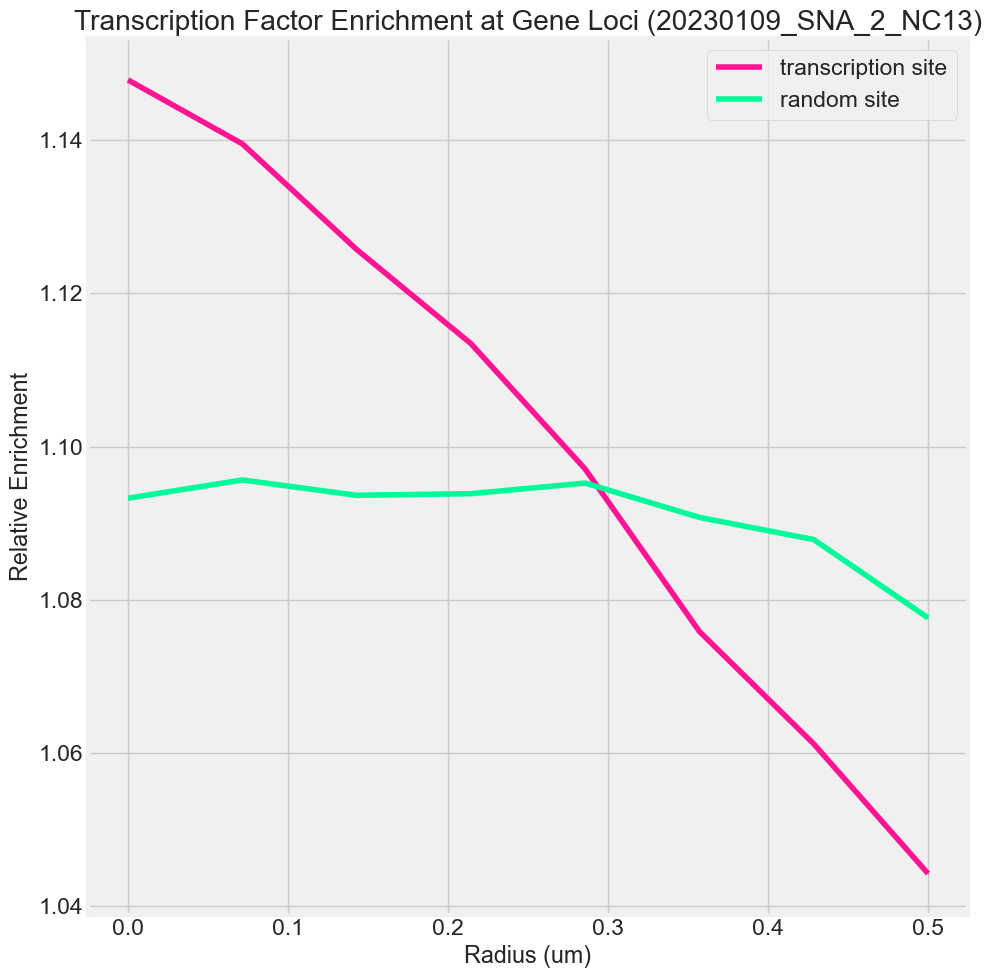

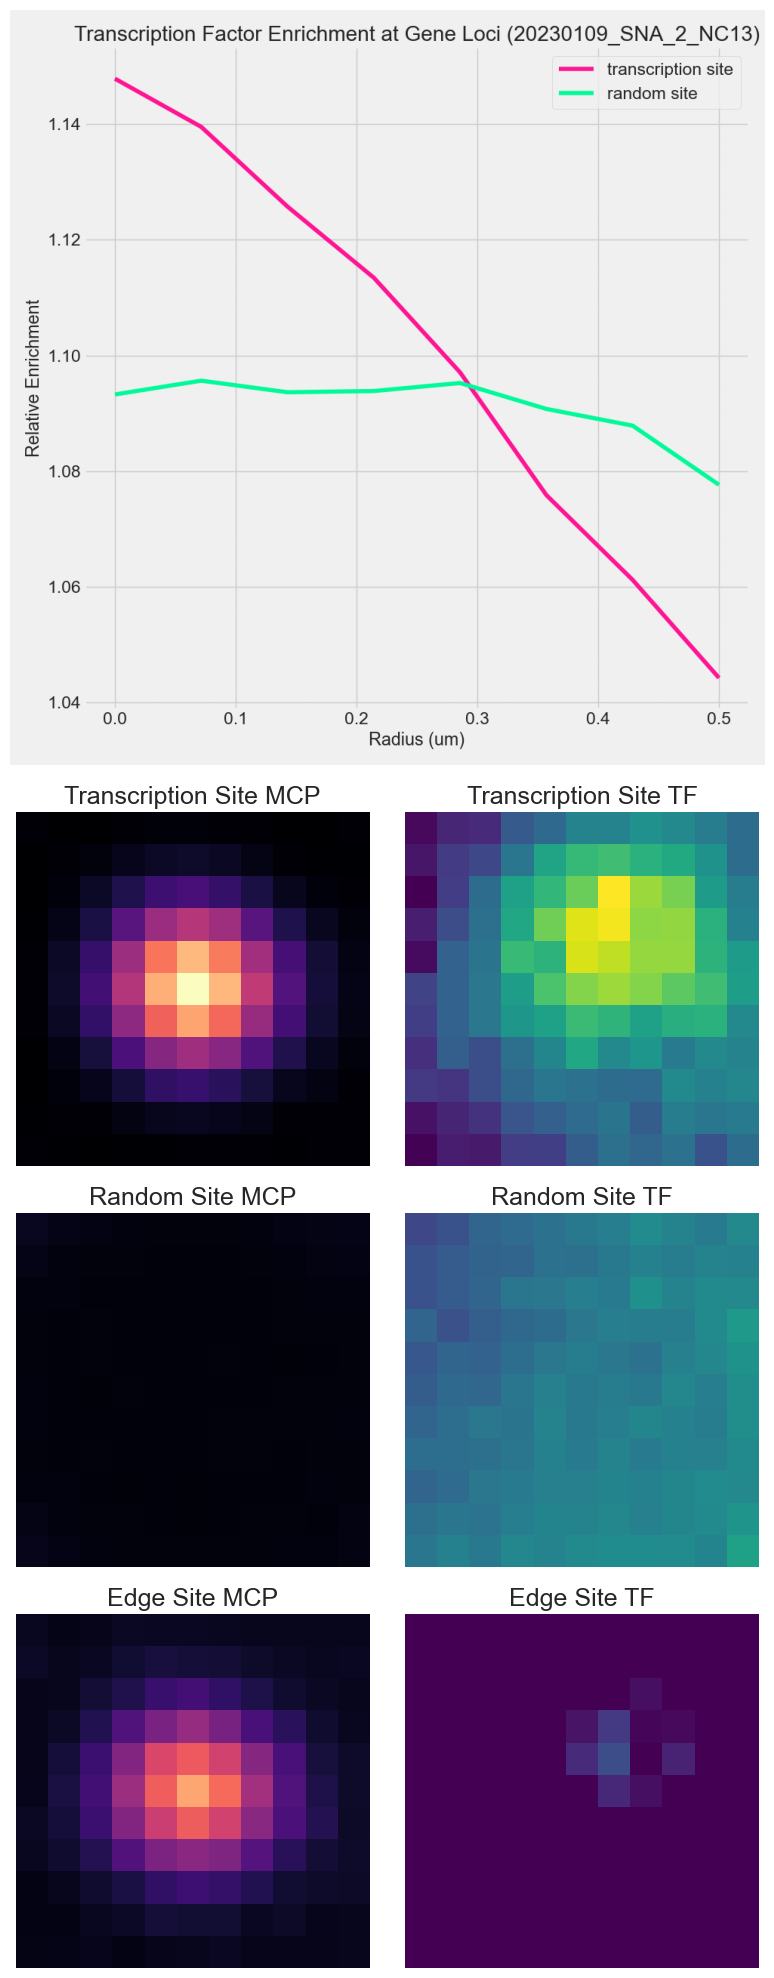

In [5]:
nuclearcycle = "NC13"

#analyze
generate_figures(dataset_parameters['Idir'],dataset_parameters['output_path'], dataset_parameters['sample_id'], nuclearcycle, window_crop = dataset_parameters['window_crop'], save_edges=dataset_parameters['save_edges'], dark_background = False) 
see_results(dataset_parameters['output_path'], dataset_parameters['sample_id'], nuclearcycle, window_crop = dataset_parameters['window_crop'], save_edges=dataset_parameters['save_edges'], dark_background = False) 